### Notebook for the hands on session 6 (Thermal conductivity calculation of cubic SrTiO3)

0. **Change directory and make symbolic links**

    ```bash
    > cd ../../6_self_consistent_phonon_STO/work
    > ln -s ../../5_self_consistent_phonon_STO/work/STO222.xml
    > ln -s ../../5_self_consistent_phonon_STO/work/STO_anharm.xml
    > ln -s ../../5_self_consistent_phonon_STO/work/STO_scph2-2.scph_dfc2
    > ln -s ../../5_self_consistent_phonon_STO/work/BORN
    ```


1. **Generate a new XML file containing renormalized harmonic force constants**

    - Run `dfc2` command
    
    ```sh
    > dfc2
     DFC2 -- a generator of renormalized harmonic FCs from SCPH outputs.
     XML file containing original FC2 : STO222.xml
     Output xml filename with anharmonic correction : STO222_scph_300K.xml
     FC2 correction file from SCPH calculation : STO_scph2-2.scph_dfc2
     Target temperature : 300
    ```
    <br>
    One liner version

    ```sh
    > dfc2 STO222.xml STO222_scph_300K.xml STO_scph2-2.scph_dfc2 300
    ```


2. **Run thermal conductivity calculation**

    Please make the temperature of thermal conductivity calculation consistent with the temperature of SCPH calculation
    by using `TMIN, TMAX` tags in `kappa.in` as follows:<br>
    
    ```
    &general
      PREFIX = STO_scph_300K
      MODE = RTA
      NKD = 3; KD = Sr Ti O
      FCSXML = STO_anharm.xml
      FC2XML = STO222_scph_300K.xml
      TMIN = 300; TMAX = 300
      NONANALYTIC = 3; BORNINFO = BORN
    /
    &cell
     7.363
     1.0 0.0 0.0
     0.0 1.0 0.0
     0.0 0.0 1.0
    /
    &kpoint
      2
      9 9 9
    /
    ```
    <br>

    - Run ANPHON
    
    ```sh
    > export OMP_NUM_THREADS=1
    > mpirun -np 4 anphon kappa.in > kappa.log
    > cat STO_scph_300K.kl
    ```


3. **Run calculations at different temperatures**

    - Create a shell script for performing calculations at various temperatures automatically:
    
    ```sh
    #!/bin/bash
    export OMP_NUM_THREADS=1
    for ((temp=200; temp<=800; temp+=100))
     do 
     dfc2 STO222.xml STO222_scph_${temp}K.xml STO_scph2-2.scph_dfc2 ${temp}
    cat << EOF > kappa${temp}.in
    &general
     PREFIX = STO_scph_${temp}K
     MODE = RTA;
     NKD = 3; KD = Sr Ti O
     FCSXML = STO_anharm.xml
     FC2XML = STO222_scph_${temp}K.xml
     TMIN = ${temp}; TMAX = ${temp}
     NONANALYTIC = 3; BORNINFO = BORN
    /
    &cell
     7.363
     1.0 0.0 0.0
     0.0 1.0 0.0
     0.0 0.0 1.0
    /
    &kpoint
     2
     9 9 9
    /
    EOF
     echo "Running kappa calculation at T = " $temp
     mpirun -np 4 anphon kappa${temp}.in > kappa${temp}.log
     echo "Done"
    done

    ```
    <br>
    
    - Run the script
    
    ```sh
    > bash ./autocalc.sh
    ```
    This takes about 20 minutes using 4 cores on TSUBAME. You can reduce the temperature sampling point by setting, for example, `temp+=200`.


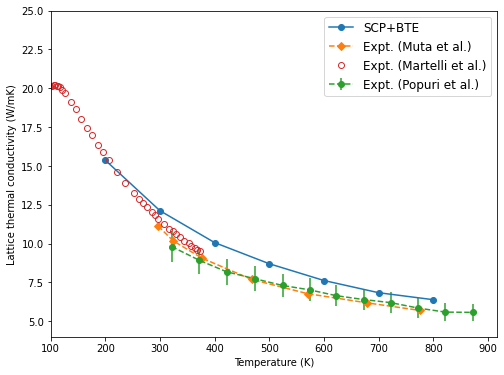

In [22]:
import matplotlib.pyplot as plt
import os
import numpy as np

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

temp_list = []
kappa_list = []
for temp in range(200, 801, 100):
    fname = 'work/STO_scph_%dK.kl' % temp
    if os.path.exists(fname):
        temp_list.append(temp)
        kappa_list.append(np.loadtxt(fname)[1])

ax.plot(temp_list, kappa_list, marker='o', linestyle='-', label='SCP+BTE')

exp_muta = np.loadtxt('data/kappa_STO.txt')
exp_popuri = np.loadtxt('data/kappa_STO_popuri.txt')
exp_martelli = np.loadtxt('data/kappa_STO_Martelli.txt')

ax.plot(exp_muta[:,0], exp_muta[:,1], linestyle='--', marker='D', label='Expt. (Muta et al.)')
ax.errorbar(x=exp_popuri[:,0], y=exp_popuri[:,1], yerr=exp_popuri[:,2], linestyle='--', marker='o', label='Expt. (Popuri et al.)')
ax.plot(exp_martelli[:,0], exp_martelli[:,1], linestyle='None', marker='o', label='Expt. (Martelli et al.)', mfc='None')
ax.set_xlim(100)
ax.set_ylim(4, 25)
ax.legend(loc='best', fontsize=12)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Lattice thermal conductivity (W/mK)")
plt.savefig('kappa.pdf', bbox_inches='tight')